In [25]:
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir
import datetime
from CRTS_paper_modules import update_progress
import os 

## Initial Sample of S82 CRTS QSO  from Branimir 

First, find how many quasars we got from Branimir : in /local/tmp/suberlak/CRTS_PROJECT/raw_LC_CRTS 
    QSO_CRTS.tar.gz  `12MB    (7932 files,  remove empty : 7753,  remove N<10 :  7707, remove Nday<10  7601)
      (same as    /astro/users/ivezic/suberlak/QSO.tar.gz   ) 

In [186]:
dir_in = '../raw_LC_CRTS/QSO_CRTS/'
QSO_arr = np.array(listdir(dir_in))
print('We have %d CRTS qso files to start with ' % len(QSO_arr))

We have 7933 CRTS qso files to start with 


In [187]:
# ignore the two files that are not lightcurves

a = np.array([len(entry) for entry in QSO_arr])
#np.unique(a)
#QSO_arr[a == 9 ]
#QSO_arr[a == 11 ]
QSO_list = list(QSO_arr)
QSO_list.remove('message.txt')
QSO_list.remove('file.list')


## Remove empty files and those with less than 10 points 

Three equivalent ways of testing for the number of empty files.  Those files should be removed from the list of accepted QSO/ 

In [188]:
c = 0 
empty_files = []
for obj in QSO_list:
    address = dir_in + obj
    f = open(address, 'r')
    if f.readline() == '' :
        c += 1
        empty_files.append(obj)
        
print('We have %d empty files' % c)    

We have 179 empty files


In [189]:
QSO_nonempty = np.array(QSO_list)[~np.in1d(QSO_list, empty_files)]  
len(QSO_nonempty)

7752

Remove those files that have less than 10 points : 

In [190]:
c = 0 
short_files = []
for obj in QSO_nonempty:
    address = dir_in + obj
    f = open(address, 'r')
    num_lines = sum(1 for line in open(dir_in+obj))
    if num_lines < 10 :
        c += 1
        short_files.append(obj)
        
print('We have %d  files with less than 10 pts ' % c) 

We have 45  files with less than 10 pts 


In [191]:
QSO_10_pts_plus = QSO_nonempty[~np.in1d(QSO_nonempty, short_files)]
len(QSO_10_pts_plus)

7707

## Make a directory to save stats and figures  

In [26]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_1_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)

# set in stone just for today since I'm continuing from yesterday
#outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_1_data/'+'2017-01-24/')
                      
print('Today we will save our Fig_1 files in %s'%outDir)

Today we will save our Fig_1 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_1_data/2017-02-24/


## Statistics on the raw  QSO  light curves 


In [195]:
QSO_10_pts_plus

array(['000011.96+000225.3.dat', '000014.82-011030.6.dat',
       '000017.88+002612.6.dat', ..., '235944.13-005738.2.dat',
       '235945.49-005819.6.dat', '235948.09+001229.5.dat'], 
      dtype='<U22')

In [254]:
dir_in = '../raw_LC_CRTS/QSO_CRTS/'
files = QSO_10_pts_plus


timespan_obs = np.zeros_like(files, dtype=float) # store what was the total  timespan of observations per object
lc_length=np.zeros_like(files, dtype=float)      # number of points in the lightcurve : epochs before day-averaging
mean_N_day = np.zeros_like(files, dtype=float)    # average nunmber of observations per day                          
mean_mag = np.zeros_like(files, dtype=float)   # mean magnitude over all epochs 
mean_err = np.zeros_like(files, dtype=float)   # mean error over all epochs 
qso_name = np.zeros_like(files)

k = 0
total = float(len(files))

for i in range(len(files)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_in+files[i]  
    data=np.loadtxt(address) 
    
    lc_length[i] = sum(1 for line in open(address))
    mean_mag[i] = np.mean(data[:,1])
    mean_err[i] = np.mean(data[:,2])
    #mean_N_day[i] = np.mean(data[:,3])
    timespan_obs[i] = data[-1,0]-data[0,0]  
    qso_name[i] = files[i][:-4]
    
keys = ['CRTS_name', 'raw_timespan_obs', 'raw_lc_length', 'raw_mean_mag', 'raw_mean_err']
values = [qso_name, timespan_obs, lc_length, mean_mag, mean_err]

stats_before={}
for key, value in zip(keys, values):
    stats_before[key] = value

[######### ] 99.00%

In [260]:
# save the raw CRTS LC  stats...
outDir = '../data_products/'
savefile = outDir+'Fig_1_raw_CRTS_QSO_LC_stats'
np.save(savefile, stats_before)

### Preprocessing : Day-averaged light curves : needs be RUN ONLY ONCE  to make them!

Make day-averaged lightcurves, save only if more than 10 observing days (points in the day-averaged light curve). 
Save MJD, avg_mag, error, N_obs that day. For our 7707 lightcurves it takes about 1.5 mins on my workstation. 

In [126]:
dir_in = '../raw_LC_CRTS/QSO_CRTS/'
dir_out = '../proc_LC_CRTS/qso/'
lc_files = QSO_10_pts_plus

k = 0
total = float(len(lc_files))

for obj in lc_files:
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_in+obj
    data=np.loadtxt(address)

    averages=np.zeros(shape=(len(data),3))

    mjd = data[:,0]
    mags = data[:,1]
    errs = data[:,2]
   
    days = np.unique([int(day) for day in data[:,0]])
    
    # storage arrays  for each qso (all N's)
    mjd_arr = np.zeros_like(days).astype(float)
    avg_mags = np.zeros_like(days).astype(float)
    avg_err_weights = np.zeros_like(days).astype(float)  
    Nobs = np.zeros_like(days).astype(float)

    # loop through days calculating mean, etc. 
    # day-averaging
    for i in range(len(days)):
        day = days[i]
        int_mjd = np.require(mjd,int)       # forcing mjd array -> integers
        condition = (int_mjd == day)        # finding where int(mjd) = day
        N = float(len(mags[condition]))            # number of obs in that night 
        Nobs[i] = N
        w=1.0 / ( errs[condition] * errs[condition]) 
        avgmag = np.average(mags[condition], weights = w)       
        avg_mags[i] = avgmag
        error_weights = 1.0 / np.sqrt(np.sum(w))
        
        # increase error if too small 
        if error_weights < 0.02 : 
            error_weights = np.sqrt(error_weights**2.0 + 0.01**2.0)  
        avg_err_weights[i] = error_weights
        mjd_arr[i] = np.mean(mjd[condition])
        
    # Save the output... 
    # Once per lightcurve 
    # ONLY IF THERE IS MORE THAN 10 OBS ! 
    
    if( len(mjd_arr) >  10 ) :
            name_out = dir_out  + 'out_'+obj[:18]+'.txt'
            # So now we are saving all the day-averaged LC's, even if the resulting length was less than 10 days... 
            # Easier to explain stats if they are ignored later. 

            # Then select only those that have more than 10 days of observations, and 
            # compare to content of the QSO_CRTS_processed_err_w/ directory, to ensure that they are the same
            np.savetxt(name_out, np.column_stack((mjd_arr, avg_mags, avg_err_weights, Nobs)),fmt='%11.4f')
    
       

[######### ] 99.00%

## Statistics on the day-averaged LC

In [22]:
dir_in = '../proc_LC_CRTS/qso/'
files = np.array(listdir(dir_in))

mjd_span = np.zeros_like(files, dtype=float) # store what was the total  timespan of observations per object
lc_length=np.zeros_like(files, dtype=float) # number of points in the lightcurve - equal to the number of obs nights
mean_N_day = np.zeros_like(files, dtype=float)
mean_mag = np.zeros_like(files, dtype=float)
mean_err = np.zeros_like(files, dtype=float)
qso_name = np.zeros_like(files)
#mean_delta_t = np.zeros_like(files, dtype=float)
median_pairwise_dt = np.zeros_like(files, dtype=float)

l = 0
total = float(len(files))

#delta_t_stack = np.zeros(0, dtype=float)

for i in range(len(files)):
    percent = 100*(l / total)
    if (l % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    l += 1

    address=dir_in+files[i]  

    mjd,flx,err, N_obs =np.loadtxt(address, usecols=(0,1,2,3), unpack=True) 
    
    lc_length[i]  = len(mjd)  # sum(1 for line in open(address))
    mean_mag[i]   = np.mean(flx)
    mean_err[i]   = np.mean(err)
    mean_N_day[i] = np.mean(N_obs)
    mjd_span[i]   = mjd[-1]-mjd[0]  # gives number of days between first and last obs
    qso_name[i]   = files[i][4:-4]
            
    # Sort according to mjd's 
    ind = np.argsort(mjd)
    mjd = mjd[ind]

    
    # Calculate tau, mag difference and err difference for each pair (k,j), 
    # where tau=t_j-t_k (j>k) 
    #  i.e.  t5-t4, t5-t3, t5-t2, t5-t1,   t4-t3,  t4-t2, t4-t1, ....
    
    #delta_t = []
    #for j in range(len(mjd)-1):
    #    # j from 1 and k<j
    #    for k in range(j+1):     
    #        delta_t.append(mjd[j+1]-mjd[k]) 
    #
    #delta_t_stack = np.append(delta_t_stack, delta_t)    # this really slows it down...     takes about 10 mins
    #mean_delta_t[i] = np.mean(np.array(delta_t))        # it's like 18 mln lines altogether! 
    
    # NOTE  2/24/2017 , IN RESPONSE TO MATTHEW GRAHAM'S COMMENTS 
    #
    # This is not needed, because people find it confusing. Replace 
    # time-differences calculated against all pairs of points, 
    # with simple pairwise time difference 
    # i.e.    t5-t4,  t4-t3,  t3-t2,  t2-t1.... 
    # and per lightcurve, calculate the median, not mean, because 
    # it is more robust against outliers... 
    
    dt = []
    for j in range(len(mjd)-1):
        dt.append(mjd[j+1]-mjd[j])

    median_pairwise_dt[i] = np.median(dt)
    
keys = ['CRTS_name', 'proc_mjd_span', 'proc_lc_length', 'proc_mean_N_day', 'proc_mean_mag', 
        'proc_mean_err', 'proc_median_dt'] #'proc_mean_delta_t'
values = [qso_name, mjd_span, lc_length, mean_N_day, mean_mag, mean_err, median_pairwise_dt]


stats_after={}
for key, value in zip(keys, values):
    stats_after[key] = value
    

[######### ] 99.00%

In [27]:
outDir

'/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_1_data/2017-02-24/'

In [28]:
# save the day-averaged (processed ) CRTS LC  stats...
#outDir = '../data_products/Fig_1_data/'
savefile = outDir+'Fig_1_proc_CRTS_QSO_LC_stats'
np.save(savefile, stats_after)



## Combine before and after  day-averaging aggregate properties of CRTS QSO into one master catalog...

In [29]:
from astropy.table import join
from astropy.table import Table


In [31]:
# read the raw LC agg info 
# 2/24/2017 - I use info from 2/9/2017,  because the raw lightcurve stats are fine 
raw_lc_agg = np.load('../data_products/Fig_1_data/2017-02-09/' + 'Fig_1_raw_CRTS_QSO_LC_stats.npy').item()
# convert a dictionary to an AstroPy Table 
raw_lc_agg_table = Table(raw_lc_agg)


In [32]:
# read the processed LC agg info
proc_lc_agg = np.load(outDir + 'Fig_1_proc_CRTS_QSO_LC_stats.npy').item()
proc_lc_agg_table = Table(proc_lc_agg)

In [33]:
# Join the two tables on CRTS_name  :

from astropy.table import join
agg_combined = join(left=raw_lc_agg_table, right = proc_lc_agg_table, keys='CRTS_name')



In [34]:
agg_combined[:5]



raw_timespan_obs,raw_mean_err,raw_lc_length,raw_mean_mag,CRTS_name,proc_mean_N_day,proc_lc_length,proc_mean_mag,proc_mjd_span,proc_mean_err,proc_median_dt
float64,float64,float64,float64,str26,float64,float64,float64,float64,float64,float64
3020.85593,0.0683333333333,138.0,17.4757971014,000011.96+000225.3,3.45,40.0,17.48116,3020.8438,0.0382175,22.837
2892.13763,0.107023809524,84.0,19.3313095238,000014.82-011030.6,4.0,21.0,19.3280952381,2892.1202,0.0533952380952,29.38975
3020.85593,0.123284671533,137.0,19.6811678832,000017.88+002612.6,3.425,40.0,19.671925,3020.8438,0.06977,22.837
2889.07825,0.152266666667,150.0,20.1694666667,000038.65+011426.3,4.05405405405,37.0,20.1422432432,2889.0603,0.0745783783784,23.4111
3020.85593,0.0779710144928,138.0,18.1111594203,000042.89+005539.5,3.45,40.0,18.115225,3020.8438,0.0439675,22.837


In [35]:
# Save the master CRTS catalog 

address = '../data_products/CRTS_qso_raw_and_proc_combined_agg.dat'
agg_combined.write(address,format='ascii', overwrite='True')



## Make Fig. 1  : statistics of the day-averaged sample of CRTS QSO .... 

In [36]:
print('We have %d day-averaged quasar lightcurves'%len(stats_after['proc_lc_length']))



We have 7601 day-averaged quasar lightcurves


In [37]:
outDir

'/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_1_data/2017-02-24/'

In [39]:
stats_after.keys()

dict_keys(['proc_mean_N_day', 'proc_mean_err', 'proc_mean_mag', 'CRTS_name', 'proc_mjd_span', 'proc_lc_length', 'proc_median_dt'])

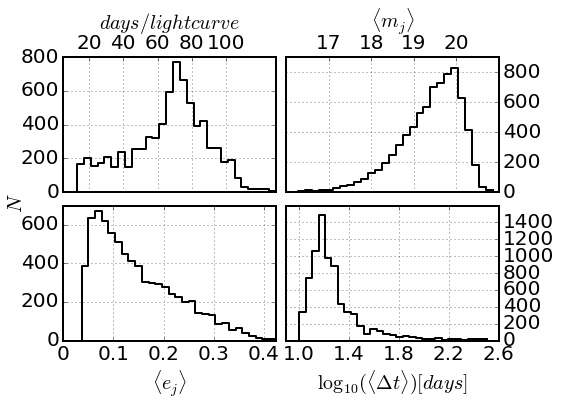

In [51]:
%matplotlib inline

#import seaborn as sns
#sns.set_context('poster')
from matplotlib import rcParams
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 20
lw = 2 

fig, axs = plt.subplots(2,2, figsize=(8,6))

ax = np.ravel(axs)

# Set number of histogram bins 
nbins = 30
lcolor = 'black'
density = False 

# Panel 1 
#ax[0].set_ylabel('count')
ax[0].set_xlabel(r'$ days / lightcurve$')
ax[0].set_xticks([0,20,40,60,80,100])
ax[0].set_xticklabels(['0','20','40','60','80','100'])
ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.tick_top()

hist, bin_edges = np.histogram(stats_after['proc_lc_length'], bins=nbins, density=density)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
hist[0]=0
ax[0].set_xlim(xmin = 5, xmax = max(bin_centres))
ax[0].plot(bin_centres, hist, ls = 'steps', lw=lw, color=lcolor)

#ax[0].hist(stats_after['lc_length'], bins=nbins, histtype='step', lw=lw, normed=False)
# make ticks less frequent 
ticks = ax[0].get_yticks()
ax[0].set_yticks(ticks[::2])
    
    
# Panel 2
#ax[1].set_ylabel('count')
ax[1].set_xlabel(r'$\langle m_{j} \rangle$')
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.tick_top()
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
a = stats_after['proc_mean_mag']
m = (a > 16) * (a < 21)
hist2, bin_edges = np.histogram(a[m], bins=nbins, density=density)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0  # start at 0 
ax[1].plot(bin_centres2, hist2, ls = 'steps', lw=lw, color=lcolor)
ticks = ax[1].get_yticks()
ax[1].set_yticks(ticks[::2])

ticks = ax[1].get_xticks()
ax[1].set_xticks(ticks[1:-1])



# Panel 3 
#ax[2].set_ylabel('count')
ax[2].set_xlabel(r'$\langle e_{j} \rangle$')
ax[2].set_xticks([0,0.1,0.2,0.3,0.4])
ax[2].set_xticklabels(['0','0.1','0.2','0.3','0.4'])
hist3, bin_edges = np.histogram(stats_after['proc_mean_err'], bins=nbins, density=density)
bin_centres3 = (bin_edges[:-1] + bin_edges[1:])/2
ax[2].set_xlim(xmin = 0, xmax = max(bin_centres3))
hist3[0]=0
ax[2].plot(bin_centres3, hist3, ls = 'steps', lw=lw, color=lcolor)
ticks = ax[2].get_yticks()
ax[2].set_yticks(ticks[::2])


# Panel 4 
#ax[3].set_ylabel('count')
ax[3].set_xlabel(r'$ \log_{10} (\langle \Delta {t} \rangle) [days] $')  
ax[3].yaxis.tick_right()
ax[3].yaxis.set_label_position("right")


hist4, bin_edges = np.histogram(np.log10(stats_after['proc_median_dt']), bins=nbins, density=density)
bin_centres4 = (bin_edges[:-1] + bin_edges[1:])/2
hist4[0]=0

ax[3].plot(bin_centres4, hist4, ls = 'steps', lw=lw, color = lcolor)
ax[3].set_xlim(0.9,2.6)
#ax[3].set_ylim(0,2100)

xticks = ax[3].get_xticks()
ax[3].set_xticks(xticks[1::2])

ticks = ax[3].get_yticks()
ax[3].set_yticks(ticks[:-1])

fig.text(0.03, 0.5, r'$N$', ha='center', va='center', rotation='vertical',fontsize=20)
#fig.text(0.96, 0.5, r'$N$', ha='center', va='center', rotation='vertical',fontsize=20)

# gridding... 
grid= True
if grid == True : 
    for i in range(4) :  
        ax[i].grid()
        

# Save
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.05)
plt.savefig(outDir + 'Fig_1_QSO_CRTS_proc_stats.png')



In [332]:
outDir


'../data_products/'

## Compare before and after preprocessing: error and mag distribution 

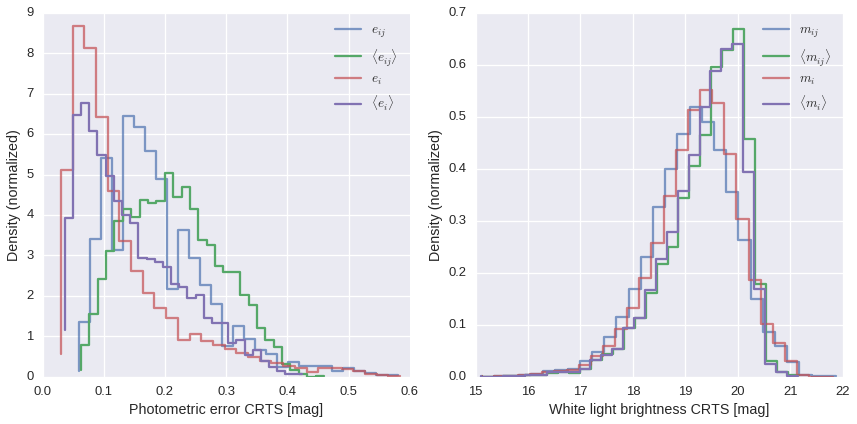

In [129]:
import seaborn as sns
sns.set_context('talk')
fig,ax = plt.subplots(1,2, figsize=(12,6))
nbins=30


# ERROR  

# Calculate the histogram1 : raw errors
hist1, bin_edges = np.histogram(stats_before['err'][stats_before['err']<0.6], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : raw errors LC averaged 
hist2, bin_edges = np.histogram(stats_before['avg_err'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax[0].plot(bin_centres1, hist1, ls = 'steps',alpha=0.7, label=r'$ e_{ij} $')
ax[0].plot(bin_centres2, hist2, ls = 'steps', label=r'$\langle e_{ij} \rangle $')

# Calculate the histogram1 : processed errors per day
hist1, bin_edges = np.histogram(stats_after['err'][stats_after['err']<0.6], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : processed ; average LC error 
hist2, bin_edges = np.histogram(stats_after['avg_err'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax[0].plot(bin_centres1, hist1, ls = 'steps', alpha=0.7,label=r'$ e_{i} $')
ax[0].plot(bin_centres2, hist2, ls = 'steps', label=r'$\langle e_{i} \rangle $')
ax[0].legend(loc='best')
ax[0].set_ylabel('Density (normalized)')
ax[0].set_xlabel('Photometric error CRTS [mag]')
ax[0].set_xlim(0,0.6)

# MAGNITUDE 

m = (stats_before['mag']>15)*(stats_before['mag']<22)

# Calculate the histogram1 : raw magnitudes
hist1, bin_edges = np.histogram(stats_before['mag'][m], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : average lightcurve raw magnitudes
hist2, bin_edges = np.histogram(stats_before['avg_mag'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax[1].plot(bin_centres1, hist1, ls = 'steps', alpha=0.7,label=r'$m_{ij}$')
ax[1].plot(bin_centres2, hist2, ls = 'steps', label=r'$\langle m_{ij}\rangle$')

m = (stats_after['mag']>15)*(stats_after['mag']<22)

# Calculate the histogram1 : processed day averaged magnitudes
hist1, bin_edges = np.histogram(stats_after['mag'][m], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : processed LC averages
hist2, bin_edges = np.histogram(stats_after['avg_mag'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax[1].plot(bin_centres1, hist1, ls = 'steps', alpha=0.7, label=r'$m_{i}$')
ax[1].plot(bin_centres2, hist2, ls = 'steps', label=r'$\langle m_{i}\rangle$')
ax[1].legend(loc='best')
ax[1].set_ylabel('Density (normalized)')
ax[1].set_xlabel('White light brightness CRTS [mag]')
plt.tight_layout()
plt.savefig('../Fig_1_extended_err_mag_CRTS_qso_properties.png')

In [186]:
np.sum(stats_after['avg_err'] < 0.3)

7108

In [183]:
np.mean(stats_before['avg_err'])

0.22069133056605572

## Compare CRTS white light mag and SDSS r mag  for QSO (2016/06/11)

In [163]:
import CRTS_paper_modules as mod
cols1, qso_cat = mod.get_qso_catalog() 


Zipping CRTS-SDSS quasars catalog from  ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS


In [135]:
qso_cat.keys()

['N_rows',
 'z',
 'g',
 'redshift',
 'i',
 'ra_SDSS',
 'dec_CRTS',
 'mjd_uniq_N',
 'r',
 'u',
 'ra_CRTS',
 'CRTS_avg_m',
 'dec_SDSS',
 'CRTS_id',
 'm_ang_deg',
 'mjd_span',
 'CRTS_avg_e']

(array([  1.00000000e+00,   7.00000000e+00,   3.10000000e+01,
          8.60000000e+01,   3.00000000e+02,   8.02000000e+02,
          1.67800000e+03,   2.74400000e+03,   1.89900000e+03,
          5.30000000e+01]),
 array([ 15.00910971,  15.63279457,  16.25647943,  16.8801643 ,
         17.50384916,  18.12753402,  18.75121888,  19.37490375,
         19.99858861,  20.62227347,  21.24595833]),
 <a list of 10 Patch objects>)

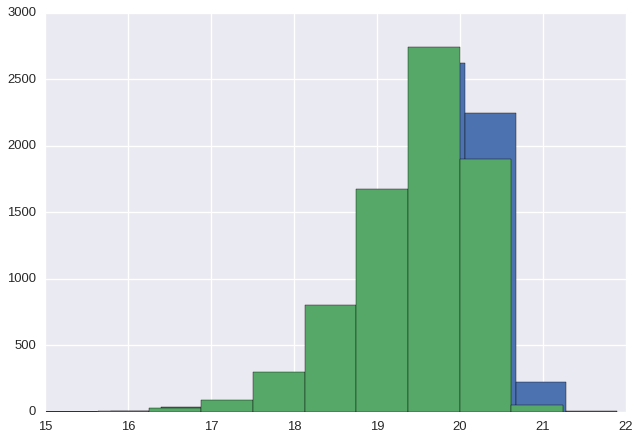

In [144]:
r = np.array(qso_cat['r']).astype(float)
m = (r > 15)*(r<22)
plt.hist(r[m])

avg_mag = np.array(qso_cat['CRTS_avg_m']).astype(float)
plt.hist(avg_mag)

In [154]:
np.sum(m)

7584

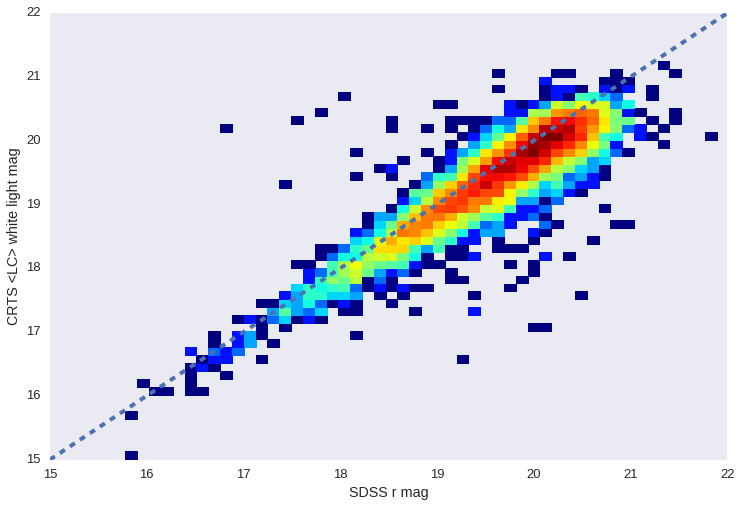

In [162]:
r = np.array(qso_cat['r']).astype(float)
m0 = (r > 15)*(r<22)

avg_mag = np.array(qso_cat['CRTS_avg_m']).astype(float)
m1 = (avg_mag>15)*(avg_mag<22)

m = m0 * m1 

fig,ax = plt.subplots()
H, xedges, yedges = np.histogram2d(r[m],avg_mag[m], bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax.plot(np.linspace(15,22), np.linspace(15,22), ls='--', lw=4)
ax.set_xlabel('SDSS r mag')
ax.set_ylabel('CRTS <LC> white light mag')
plt.tight_layout()
plt.savefig('../Fig_1_QSO_CRTS_vs_SDSS_r_magnitudes.png')

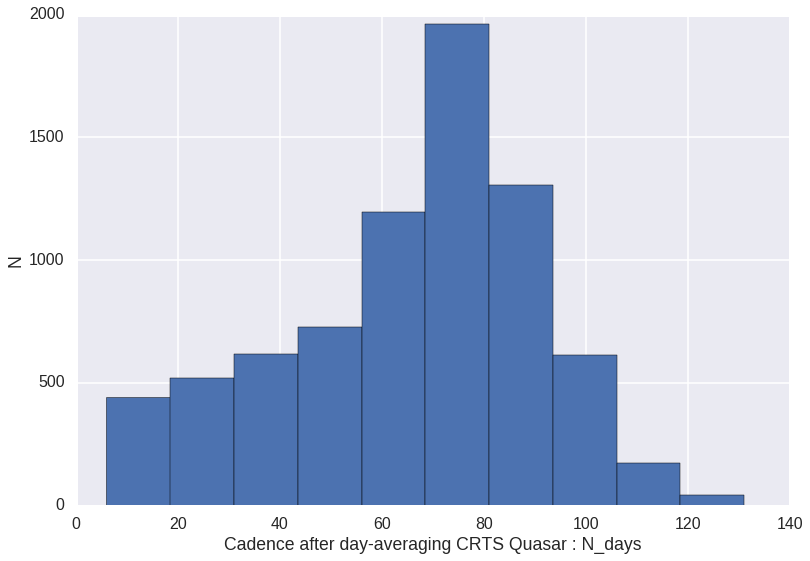

In [98]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Cadence after day-averaging CRTS Quasar : N_days')
ax.hist(stats_dict['lc_length'])
plt.savefig('../QSO_CRTS_AVG_stats_lc_length_NEW.png')

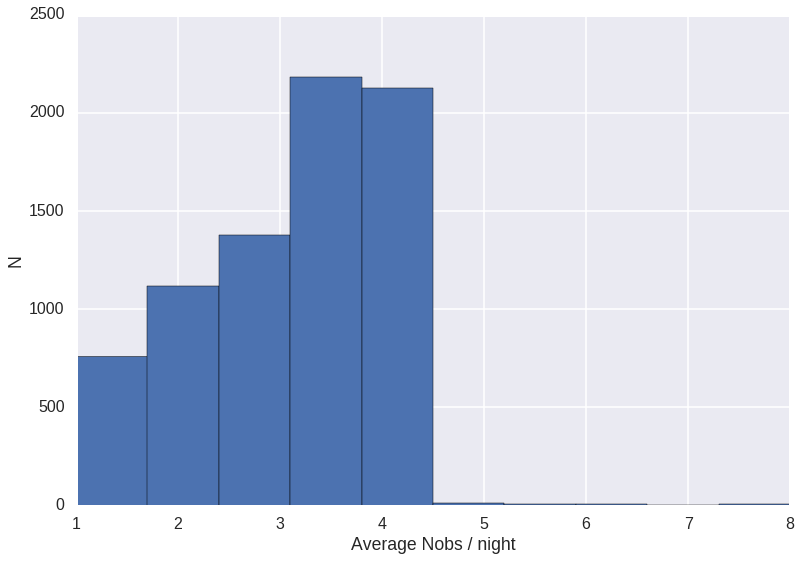

In [99]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average Nobs / night')
ax.hist(stats_dict['avg_N_day'])
plt.savefig('../QSO_CRTS_AVG_stats_N_days_per_QSO.png')

### Statistics of the day-averaged light curves (read-in previously made LCs) ( 2015/12 ) 

Find out what are the stats for the 7601 quasar light curves that are longer than 10 days. 
Each lightcurve has three columns :
MJD, average_magnitude,  error (as calculated above), N_points_per_day

In [75]:
dir_err_w = '../../SDSS_CRTS/QSO_CRTS_LC_day_averaged_err_w/'
files = np.array(listdir(dir_err_w))

# make an array for storing total timespan of obs per object, 
# as well as the total number of nights per object
timespan_obs = np.zeros_like(files, dtype=float) # store what was the total  timespan of observations per object
lc_length=np.zeros_like(files, dtype=float) # number of points in the lightcurve - equal to the number of obs nights
avg_N_day = np.zeros_like(files, dtype=float)
avg_mag_ttl= np.zeros_like(files, dtype=float)
avg_err_ttl= np.zeros_like(files, dtype=float)
avg_mjd_diff= np.zeros_like(files, dtype=float)

k = 0
total = float(len(files))

for i in range(len(files)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_err_w+files[i]  
    data=np.loadtxt(address) 
    
    lc_length[i] = sum(1 for line in open(address))
    avg_mag_ttl[i] = np.mean(data[:,1])
    avg_err_ttl[i] = np.mean(data[:,2])
    avg_N_day[i] = np.mean(data[:,3])
    timespan_obs[i] = data[-1,0]-data[0,0]  # gives number of days between first and last obs
    
    
    # the 
    mjd_diff = np.zeros(len(data[:,0]))
    for j in range(len(data)-1):
        mjd_diff[j] = data[j+1,0] - data[j,0]
    avg_mjd_diff[i] = np.mean(mjd_diff)     # avg span between obs in MJD      

keys = ['timespan_obs', 'lc_length', 'avg_N_day', 'avg_mag_ttl', 'avg_err_ttl', 'avg_mjd_diff']
values = [timespan_obs,lc_length,avg_N_day,avg_mag_ttl,avg_err_ttl,avg_mjd_diff]


stats_dict1={}
for key, value in zip(keys, values):
    stats_dict1[key] = value
    

[######### ] 99.00%


## Compare 2016/06  with 2015/05 .... 

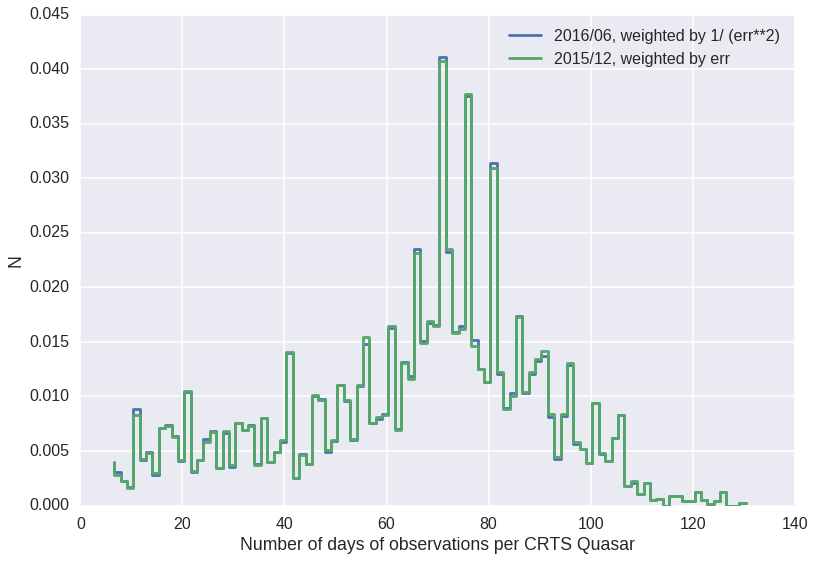

In [79]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Number of days of observations per CRTS Quasar')

nbins=100
# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['lc_length'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict1['lc_length'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='2016/06, weighted by 1/ (err**2)')
ax.plot(bin_centres2, hist2, ls = 'steps', label='2015/12, weighted by err ')
ax.legend()

plt.savefig('../QSO_CRTS_AVG_stats_lc_length_COMP.png')



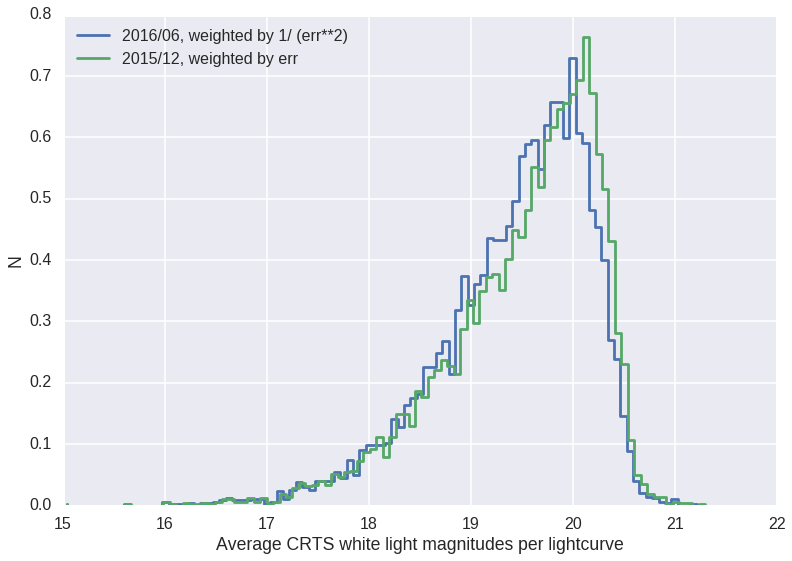

In [88]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average CRTS white light magnitudes per lightcurve')

nbins=100
# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['avg_mag_ttl'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict1['avg_mag_ttl'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_centres1, hist1, ls = 'steps', label='2016/06, weighted by 1/ (err**2)')
ax.plot(bin_centres2, hist2, ls = 'steps', label='2015/12, weighted by err ')
ax.legend(loc='best')

plt.savefig('../QSO_CRTS_AVG_stats_avg_mjd_COMP.png')



So there is a difference !   Must redo all calculations with NEW data   - because now I know exactly what's going on. Plot other statistics below... 

In [82]:
# What is the mean and median magnitude ? 
print(np.mean(stats_dict['avg_mag_ttl']))
print(np.median(stats_dict['avg_mag_ttl']))

19.4616339218
19.5995789474


# Some old things are below (Dec 2015 - February  2016 )

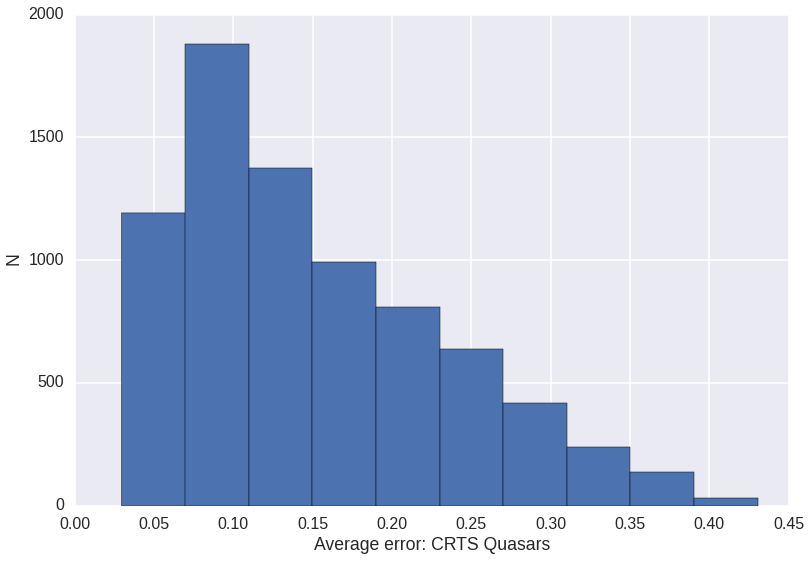

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average error: CRTS Quasars')
ax.hist(stats_dict['avg_err_ttl'])
plt.savefig('QSO_CRTS_AVG_stats_avg_err.png')

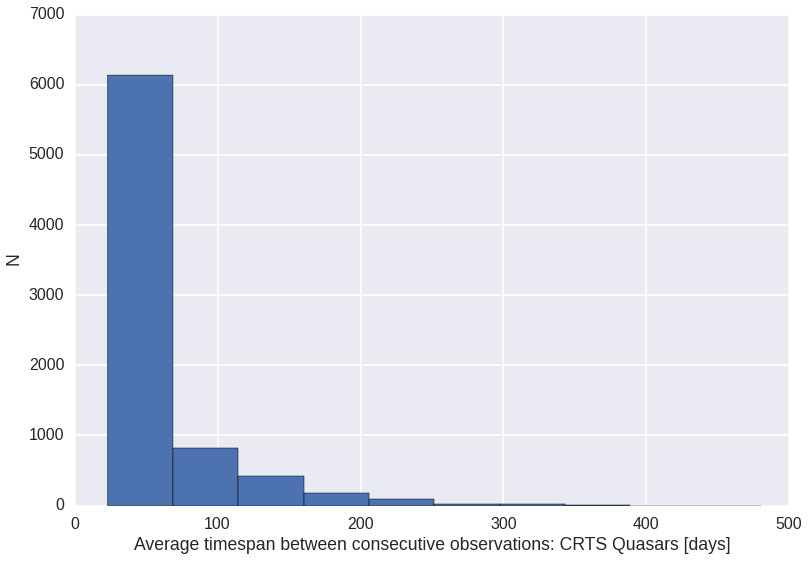

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average timespan between consecutive observations: CRTS Quasars [days]')
ax.hist(stats_dict['avg_mjd_diff'])
plt.savefig('QSO_CRTS_AVG_observations_cadence.png')

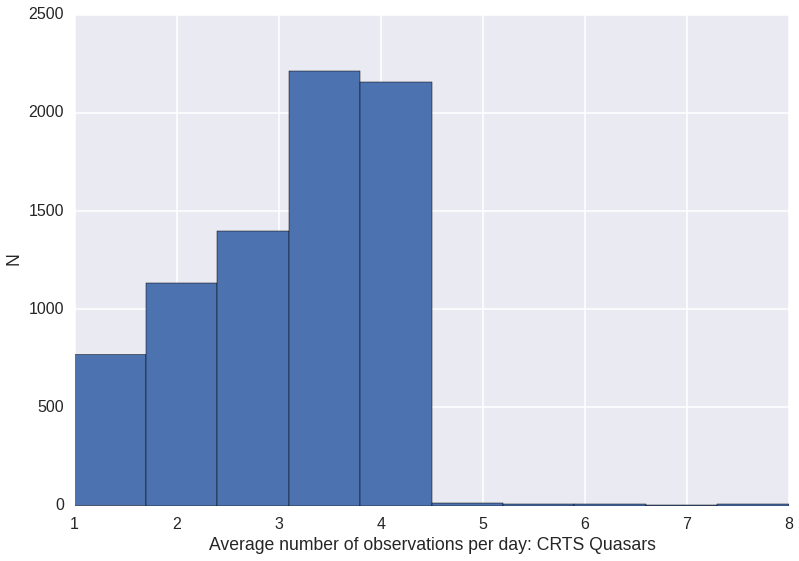

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average number of observations per day: CRTS Quasars')
ax.hist(stats_dict['avg_N_day'])
plt.savefig('QSO_CRTS_AVG_N_obs_per_day.png')

In [23]:
# How many lightcurves have on average more than 4 day of obs per day ? 
np.sum(avg_N_day > 4)

293

In [24]:
# How many lightcurves have less than 10 days of obs ? 
np.sum(lc_length < 10)

90

In [25]:
# How many lightcurves have between 1 and 4 obs ? 
np.sum((avg_N_day < 4) * (avg_N_day >1))

7035

In [26]:
len(avg_N_day)

7707

### Sanity check : plot light curves... 

For diagnostics : print the averaged LC  

QSO_CRTS_LC_day_averaged_err_w/out_235948.09+001229.5.txt


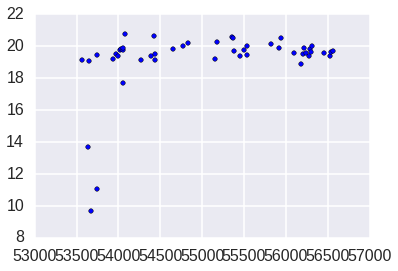

In [43]:
%matplotlib inline 
i=0
address=dir_err_w+files[i]  
data=np.loadtxt(address) 
plt.scatter(data[:,0], data[:,1])
print address

And print the original LC.... 

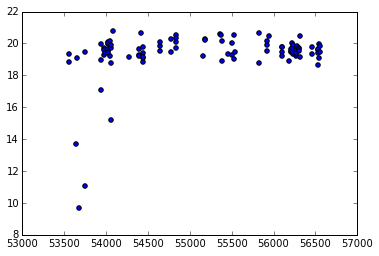

In [37]:
address = 'QSO_CRTS_LC_longer_10/' + files[i][4:-3]+'dat'
data=np.loadtxt(address) 
plt.scatter(data[:,0], data[:,1])

In [58]:
# Check whether this happens often... calculate the scatter of points...

rms = np.sqrt(np.mean(np.square(data[:,1])))

In [62]:
scatt = np.zeros_like(files, dtype=float)

for i in range(len(files)):
    address=dir_err_w+files[i]  
    data=np.loadtxt(address) 
    scatt[i] = np.mean(data[:,1]) - min(data[:,1])

Number of light curves affected :
353


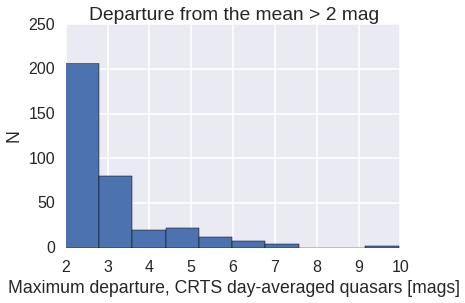

In [74]:
cutoff = 2 # how many mags away from the mean can the farthest point be? 
print('Number of light curves affected :')
print(np.sum(scatt>cutoff))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Departure from the mean > '+str(cutoff)+' mag')
ax.set_ylabel('N')
ax.set_xlabel('Maximum departure, CRTS day-averaged quasars [mags]')
ax.hist(scatt[scatt>cutoff])
plt.savefig('QSO_CRTS_AVG_scatter_from_the_mean.png')


## Sanity check : compare to stats of  QSO_CRTS_processed_err_w LC's

Calculate the statistical info of those processed day-averaged light curves that I used before, from QSO_CRTS_processed_err_w.tar.gz . It is exactly the same number of lightcurves, so the selection works identically and predictably. 

In [5]:
dir_err_w = 'QSO_CRTS_processed_err_w/'
files = np.array(listdir(dir_err_w))

# make an array for storing total timespan of obs per object, 
# as well as the total number of nights per object
timespan_obs = np.zeros_like(files, dtype=float) # store what was the total  timespan of observations per object
lc_length=np.zeros_like(files, dtype=float) # number of points in the lightcurve - equal to the number of obs nights
#avg_N_day = np.zeros_like(files, dtype=float)
avg_mag_ttl= np.zeros_like(files, dtype=float)
avg_err_ttl= np.zeros_like(files, dtype=float)
avg_mjd_diff= np.zeros_like(files, dtype=float)

k = 0
total = float(len(files))

for i in range(len(files)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_err_w+files[i]  
    data=np.loadtxt(address) 
    
    lc_length[i] = sum(1 for line in open(address))
    avg_mag_ttl[i] = np.mean(data[:,1])
    avg_err_ttl[i] = np.mean(data[:,2])
    #avg_N_day[i] = np.mean(data[:,3])
    assert data[-1,0] == max(data[:,0])
    assert data[0,0] == min(data[:,0])
    timespan_obs[i] = data[-1,0]-data[0,0]  # gives number of days between first and last obs
    # we assume it's sorted! 
    
    
    # the 
    mjd_diff = np.zeros(len(data[:,0]))
    for j in range(len(data)-1):
        mjd_diff[j] = data[j+1,0] - data[j,0]
    avg_mjd_diff[i] = np.mean(mjd_diff)     # avg span between obs in MJD : <cadence>       


stats_dict_old={'timespan_obs':timespan_obs,
               'lc_length' : lc_length,   # Number of epochs 
               'avg_mag_ttl': avg_mag_ttl,
               'avg_err_ttl' :avg_err_ttl,
              'avg_mjd_diff' :  avg_mjd_diff }


[######### ] 99.00%


66.1345875543


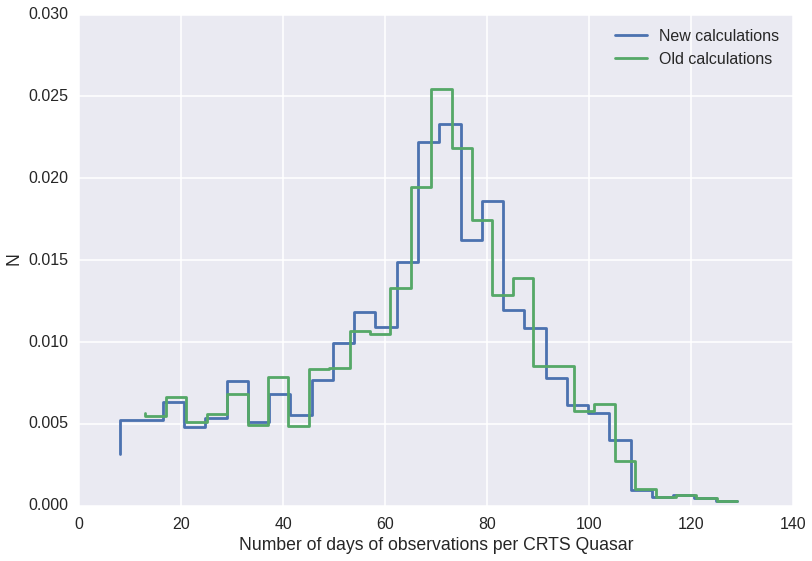

In [65]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Number of days of observations per CRTS Quasar')

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['lc_length'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['lc_length'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_stats_lc_length_comp.png')

# What is the mean number of days per Quasar ? 
print(np.mean(lc_length))



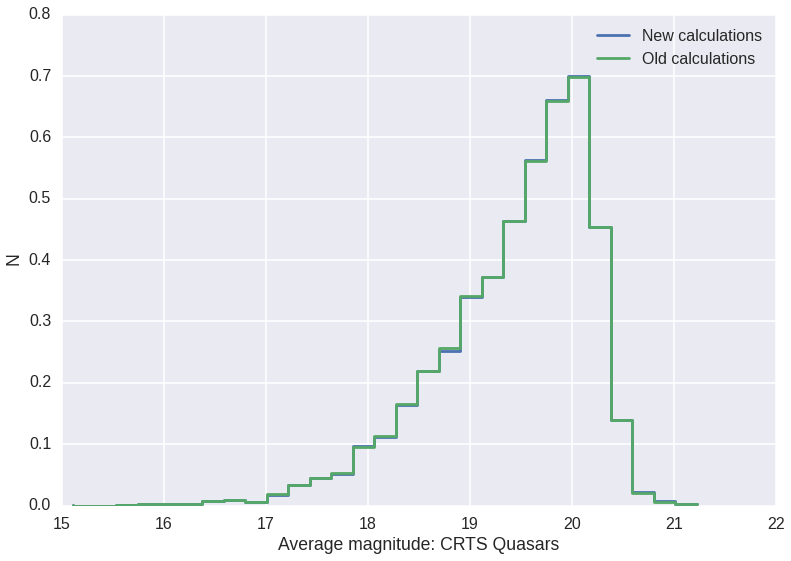

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average magnitude: CRTS Quasars')

nbins = 30

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['avg_mag_ttl'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['avg_mag_ttl'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_stats_avg_mag_comp.png')

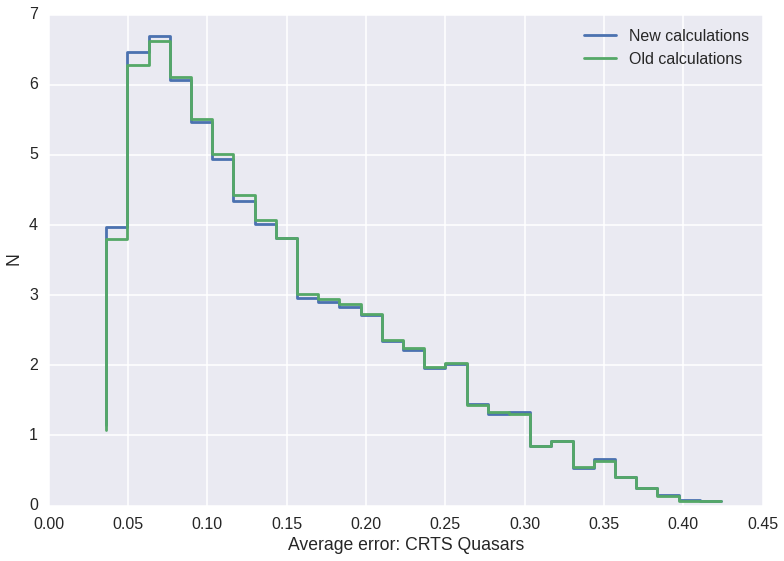

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average error: CRTS Quasars')

nbins = 30

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['avg_err_ttl'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['avg_err_ttl'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_stats_avg_err_comp.png')

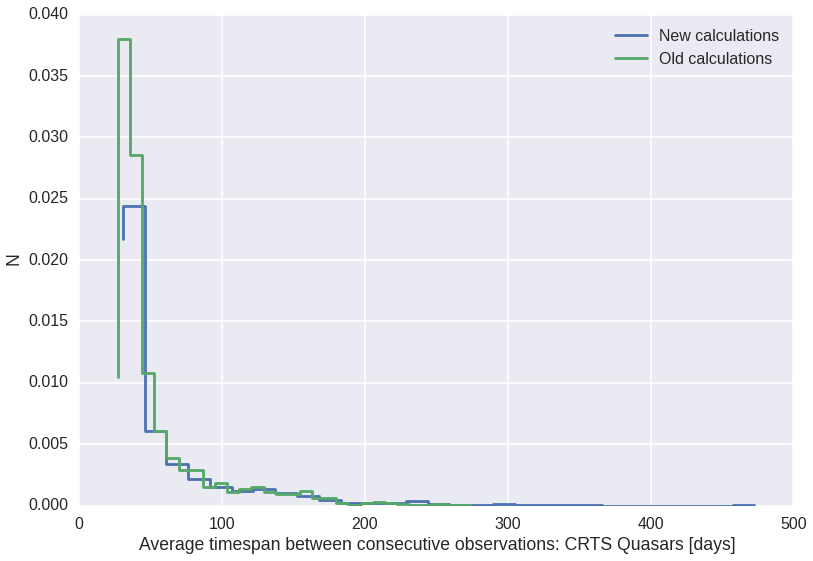

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('N')
ax.set_xlabel('Average timespan between consecutive observations: CRTS Quasars [days]')

nbins = 30

# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_dict['avg_mjd_diff'], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_dict_old['avg_mjd_diff'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label='New calculations')
ax.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')
ax.legend()

plt.savefig('QSO_CRTS_AVG_observations_cadence_comp.png')

Note : Nobs per day cannot be compared between the old and new preprocessing (making day-averaged error-weigted light curves), because this information was not stored anywhere when making them for the first time... 

But otherwise, it looks pretty nice ! It seems that I am getting almost exactly the same with my current day-averaging... However, I am suprised that they are not exactly the same..e

## Make a four-panel stats plot only about data that were actually used... 

CRTS Quasars: sample of 7601


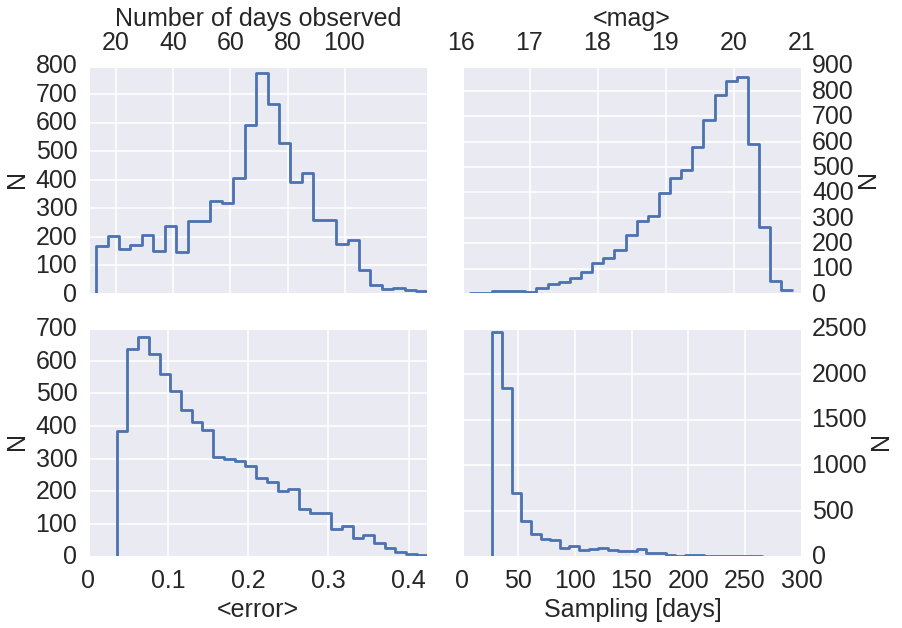

In [31]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
from matplotlib import rcParams
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25

fig = plt.figure()
fig.subplots_adjust(hspace=0.15)
fig.subplots_adjust(wspace=0.1)
print('CRTS Quasars: sample of 7601')
# Set number of histogram bins 
nbins = 30


# Panel 1 
ax1 = fig.add_subplot(221)
ax1.set_ylabel('N')
ax1.set_xlabel('Number of days observed')
ax1.set_xticks([0,20,40,60,80,100])
ax1.set_xticklabels(['0','20','40','60','80','100'])

ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
hist2, bin_edges = np.histogram(stats_dict_old['lc_length'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0
ax1.set_xlim(xmin = 10, xmax = max(bin_centres2))
ax1.plot(bin_centres2, hist2, ls = 'steps')

# Panel 2 
ax2 = fig.add_subplot(222)
ax2.set_ylabel('N')
ax2.set_xlabel('<mag>')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
a = stats_dict_old['avg_mag_ttl']
m = (a > 16) * (a < 21)
hist2, bin_edges = np.histogram(a[m], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0  # start at 0 

ax2.plot(bin_centres2, hist2, ls = 'steps')

# Panel 3 
ax3 = fig.add_subplot(223)
ax3.set_ylabel('N')
ax3.set_xlabel('<error>')
ax3.set_xticks([0,0.1,0.2,0.3,0.4])
ax3.set_xticklabels(['0','0.1','0.2','0.3','0.4'])

hist2, bin_edges = np.histogram(stats_dict_old['avg_err_ttl'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
ax3.set_xlim(xmin = 0, xmax = max(bin_centres2))
hist2[0]=0

ax3.plot(bin_centres2, hist2, ls = 'steps')

# Panel 4 
ax4 = fig.add_subplot(224)
ax4.set_ylabel('N')
ax4.set_xlabel('Sampling [days]')  # time between consecutive observations
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

hist2, bin_edges = np.histogram(stats_dict_old['avg_mjd_diff'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0

ax4.plot(bin_centres2, hist2, ls = 'steps', label='Old calculations')


# Save

plt.savefig('QSO_CRTS_AVG_stats_USED_data_four_panels.png')



## MISFILTERING ? From original to day-averaged , longer than 10 days... Compare the files.  

CRTS  : compare  QSO_CRTS_processed_err_w/   to QSO_CRTS_LC_day_averaged_err_w/   -  ought be exactly the same, and yet the stats are not exactly the same... check why!  

In [2]:
pwd

u'/astro/users/suberlak/Desktop/SDSS'

In [3]:
dir1 = 'QSO_CRTS_processed_err_w/'
dir2 = 'QSO_CRTS_LC_day_averaged_err_w/'
qso_old = listdir(dir1)
qso_new = listdir(dir2)

In [7]:
np.sum(~np.in1d(qso_new, qso_old))

0